In [1]:
import matplotlib.pyplot as plt

def plot_network(node_positions, connections, site):
    """
    Plot a network with nodes, connections, and optional special nodes (sites).
    
    Parameters:
        - node_positions: Array of shape (N, 2), where each row is the (x, y) position of a node.
        - connections: List of tuples representing edges between nodes.
        - site: Optional array of node indices for special nodes (e.g., cul-de-sacs).
    """
    plt.figure(figsize=(8, 6))
    
    # Plot connections (edges)
    for start, end in connections:
        x_coords = [node_positions[start, 0], node_positions[end, 0]]
        y_coords = [node_positions[start, 1], node_positions[end, 1]]
        plt.plot(x_coords, y_coords, color='black', linestyle='-', alpha=0.5)
    
    # Plot all nodes
    for i, (x, y) in enumerate(node_positions):
        plt.scatter(x, y, color='black', s=10, zorder=3)
        plt.text(x + 2, y + 2, str(i), fontsize=6, zorder=4)
    
    # Highlight sites in a different color
    for s in site:
        x, y = node_positions[s]
        plt.scatter(x, y, color='red', s=20, zorder=5)  # Red color for special nodes

    # Labels and display
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Network Plot")
    plt.grid(True)
    plt.show()


In [2]:
import numpy as np

def duplicate_network(node, connections, site, line_start_idx, line_end_idx):
    """
    Duplicate a network mirrored along the axis of symmetry defined by two nodes (line_start_idx, line_end_idx).
    Overlapping nodes (those on the symmetry line) are removed.
    
    Parameters:
    - node: np.ndarray, array of node coordinates.
    - connections: list of tuples, original connections.
    - site: np.ndarray, array of important nodes (cul-de-sacs).
    - line_start_idx: int, index of the first node defining the symmetry line.
    - line_end_idx: int, index of the second node defining the symmetry line.
    
    Returns:
    - all_nodes: np.ndarray, array of coordinates including original and mirrored nodes.
    - all_connections: list of tuples, updated list of connections.
    - extended_site: np.ndarray, updated list of important nodes.
    """
    # Define the symmetry line
    line_start = node[line_start_idx]
    line_end = node[line_end_idx]
    axis_direction = line_end - line_start
    axis_direction /= np.linalg.norm(axis_direction)  # Normalize

    def reflect_point(point, line_start, axis_direction):
        """Reflect a point about a line defined by a point and direction."""
        diff = point - line_start
        projection = np.dot(diff, axis_direction) * axis_direction
        perpendicular = diff - projection
        return point - 2 * perpendicular

    def is_on_symmetry_line(point, line_start, axis_direction, tolerance=1e-6):
        """Check if a point lies on the symmetry line."""
        diff = point - line_start
        perpendicular = diff - np.dot(diff, axis_direction) * axis_direction
        return np.linalg.norm(perpendicular) < tolerance

    # Generate mirrored nodes
    mirrored_nodes = []
    node_mapping = {}  # Map original indices to mirrored indices

    for i in range(len(node)):
        if is_on_symmetry_line(node[i], line_start, axis_direction):
            node_mapping[i] = i  # Nodes on the axis remain the same
        else:
            reflected = reflect_point(node[i], line_start, axis_direction)
            mirrored_nodes.append(reflected)
            node_mapping[i] = len(node) + len(mirrored_nodes) - 1  # Map to new mirrored index

    # Add mirrored connections
    mirrored_connections = []
    for start, end in connections:
        if start in node_mapping and end in node_mapping:
            mirrored_connections.append((node_mapping[start], node_mapping[end]))

    # Extend the site array to include mirrored important nodes
    mirrored_sites = [node_mapping[s] for s in site if not is_on_symmetry_line(node[s], line_start, axis_direction)]
    extended_site = np.concatenate([site, mirrored_sites])

    # Combine original and mirrored nodes
    all_nodes = np.vstack([node, mirrored_nodes])

    # Combine original and mirrored connections
    all_connections = connections + mirrored_connections

    return all_nodes, all_connections, extended_site

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Original Nodes
NUM_NODES = 17
node = np.zeros([NUM_NODES, 2], dtype=np.float32)
node[1] = np.array([100., 0.])
node[2] = np.array([100., 20.])
node[3] = np.array([200., 0.])
node[4] = np.array([100., 100.])
node[5] = np.array([0., 150.])
node[6] = np.array([20., 150.])
node[7] = np.array([180., 150.])
node[8] = np.array([200., 150.])
node[9] = np.array([0., 200.])
node[10] = np.array([100., 200.])
node[11] = np.array([200., 200.])
node[12] = np.array([100., 60.])
node[13] = np.array([0., 50.])
node[14] = np.array([-20., 50.])
node[15] = np.array([200., 50.])
node[16] = np.array([220., 50.])

# Connections
connections = [
    (0, 1), (0, 4), (0, 13), (1, 2), (1, 3), (3, 4), (3, 15), 
    (4, 10), (5, 6), (5, 9), (5, 13), (7, 8), (8, 11), (8, 15), 
    (9, 10), (10, 11), (4, 12), (13, 14), (15, 16)
]

# Important nodes (cul-de-sacs)
site = np.array([2, 6, 7, 12, 14, 16], dtype=np.int32)

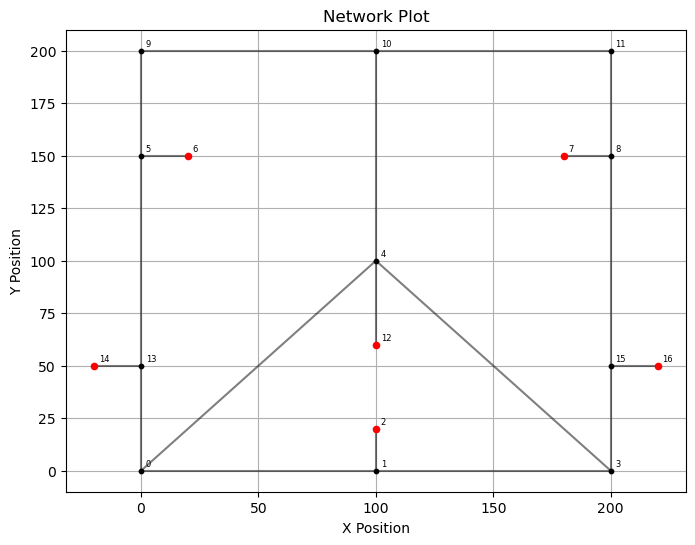

In [4]:
plot_network(node, connections, site)

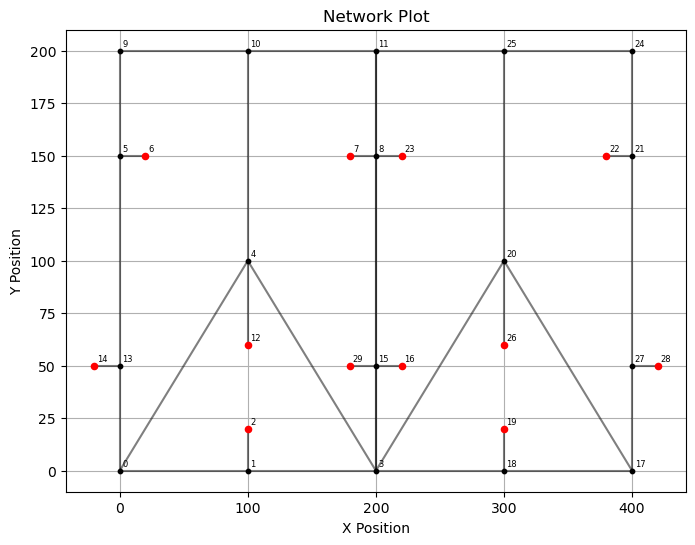

In [5]:
node, connections, site = duplicate_network(node, connections, site, 3, 11)
plot_network(node, connections, site)

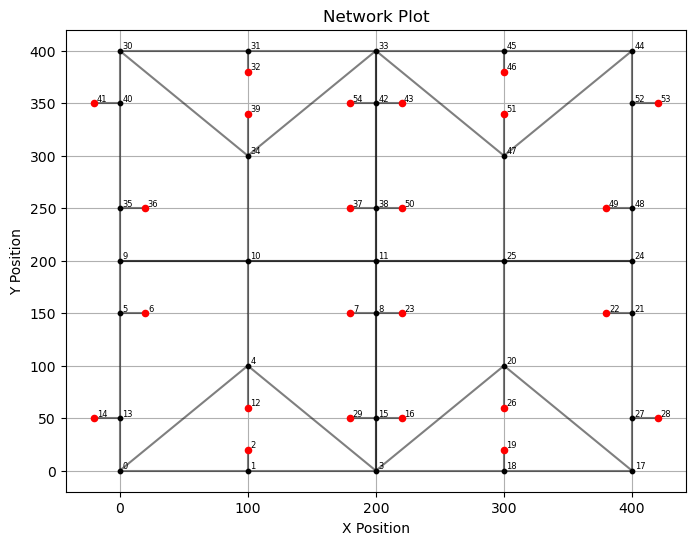

In [6]:
node, connections, site = duplicate_network(node, connections, site, 9, 24)
plot_network(node, connections, site)

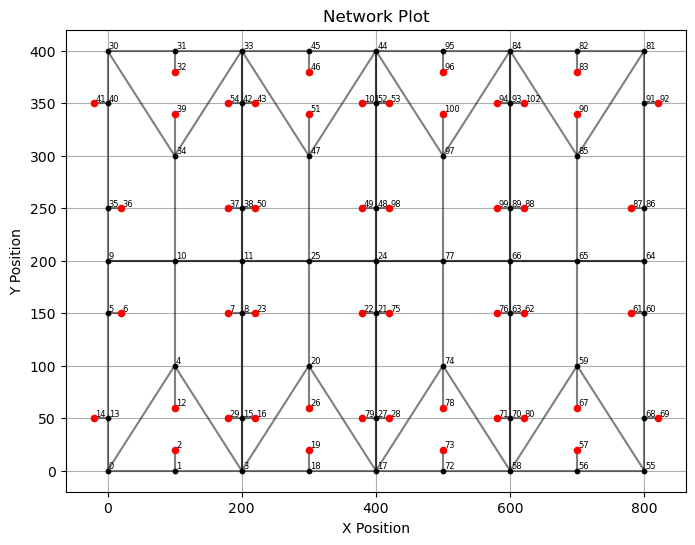

In [7]:
node, connections, site = duplicate_network(node, connections, site, 17, 44)
plot_network(node, connections, site)

In [8]:
NUM_NODES = node.shape[0]
print("NUM_NODES", NUM_NODES)
NUM_CONNECTIONS = np.array(connections).shape[0]
print("NUM_CONNECTIONS", NUM_CONNECTIONS)
# Define exit nodes manually (indices of new special nodes)
exits = np.array([103, 104, 105, 106], dtype=np.int32)  # Example indices, update as needed

# Add the new exit nodes to the node array
exit_positions = np.array([
    [node[0, 0], node[0, 1] - 100.],     # Exit 0
    [node[55, 0], node[55, 1] - 100.],   # Exit 1
    [node[30, 0], node[30, 1] + 100.],   # Exit 2
    [node[81, 0], node[81, 1] + 100.]    # Exit 3
])
######  IMPORTANT NOTE:###### 
#exits must be far enouhh so gbfs() never chooses them for the path 

# Extend the node array
node = np.vstack([node, exit_positions])

# Define connections for exits (adjust as necessary)
exit_connections = [
    (0, 103),  
    (55, 104),
    (30, 105),
    (81, 106),
]

# Extend the connections list
connections.extend(exit_connections)
# Include exits in sites
site = np.concatenate([site, exits])
#Exits are also sites ouside the map unless the status is -1. 
#In that case they are the final exit. 
print("Add exits...")

NUM_NODES = node.shape[0]
print("NUM_NODES", NUM_NODES)
NUM_CONNECTIONS = np.array(connections).shape[0]
print("NUM_CONNECTIONS", NUM_CONNECTIONS)

NUM_NODES 103
NUM_CONNECTIONS 152
Add exits...
NUM_NODES 107
NUM_CONNECTIONS 156


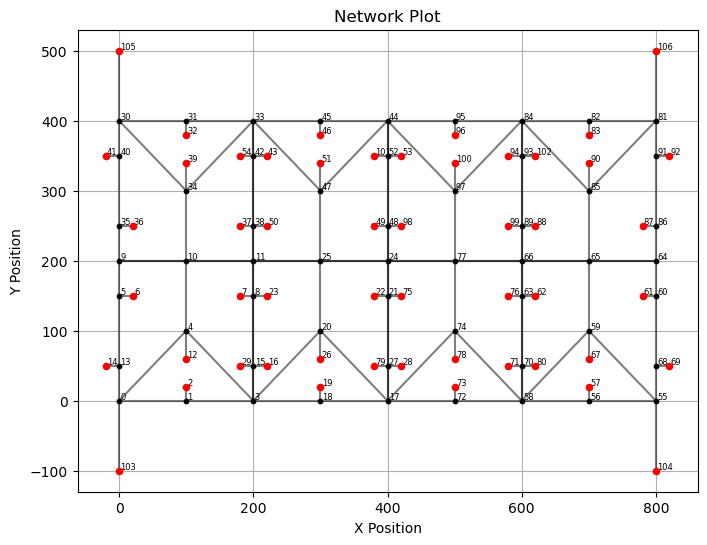

In [9]:
plot_network(node, connections, site)

In [10]:
connectivity_matrix = np.zeros((NUM_NODES, NUM_NODES), dtype=bool)

# Populate the matrix
for start, end in connections:
    connectivity_matrix[start, end] = True
    connectivity_matrix[end, start] = True  

In [11]:
connections = np.array(connections, dtype=np.int32)
mask = connections[:, 0] > connections[:, 1]  # Find rows where i > j
connections[mask] = connections[mask][:, ::-1]  # Swap columns where needed
connections = np.unique(connections, axis=0)  # Remove duplicates & sort

In [12]:
print(connections)
NUM_CONNECTIONS = connections.shape[0]
print("NUM_CONNECTIONS = ", NUM_CONNECTIONS)

[[  0   1]
 [  0   4]
 [  0  13]
 [  0 103]
 [  1   2]
 [  1   3]
 [  3   4]
 [  3  15]
 [  3  18]
 [  3  20]
 [  4  10]
 [  4  12]
 [  5   6]
 [  5   9]
 [  5  13]
 [  7   8]
 [  8  11]
 [  8  15]
 [  8  23]
 [  9  10]
 [  9  35]
 [ 10  11]
 [ 10  34]
 [ 11  25]
 [ 11  38]
 [ 13  14]
 [ 15  16]
 [ 15  29]
 [ 17  18]
 [ 17  20]
 [ 17  27]
 [ 17  72]
 [ 17  74]
 [ 18  19]
 [ 20  25]
 [ 20  26]
 [ 21  22]
 [ 21  24]
 [ 21  27]
 [ 21  75]
 [ 24  25]
 [ 24  48]
 [ 24  77]
 [ 25  47]
 [ 27  28]
 [ 27  79]
 [ 30  31]
 [ 30  34]
 [ 30  40]
 [ 30 105]
 [ 31  32]
 [ 31  33]
 [ 33  34]
 [ 33  42]
 [ 33  45]
 [ 33  47]
 [ 34  39]
 [ 35  36]
 [ 35  40]
 [ 37  38]
 [ 38  42]
 [ 38  50]
 [ 40  41]
 [ 42  43]
 [ 42  54]
 [ 44  45]
 [ 44  47]
 [ 44  52]
 [ 44  95]
 [ 44  97]
 [ 45  46]
 [ 47  51]
 [ 48  49]
 [ 48  52]
 [ 48  98]
 [ 52  53]
 [ 52 101]
 [ 55  56]
 [ 55  59]
 [ 55  68]
 [ 55 104]
 [ 56  57]
 [ 56  58]
 [ 58  59]
 [ 58  70]
 [ 58  72]
 [ 58  74]
 [ 59  65]
 [ 59  67]
 [ 60  61]
 [ 60  64]

In [13]:
import numpy as np

def build_connections_start_idx(connections, num_nodes):
    """
    Creates an array that maps each node `i` to the starting index of its connections in `connections`.
    Assumes `connections` is sorted and `i < j`.
    """
    connections_start_idx = np.full(num_nodes, -1, dtype=np.int32)  # Default: -1 (no connections)

    for k in range(connections.shape[0]):  # Scan all connections
        i = connections[k, 0]  # Get the first node in (i, j)
        if connections_start_idx[i] == -1:  # If it's the first time we see this node
            connections_start_idx[i] = k  # Store the starting index

    return connections_start_idx


In [14]:
connections_start_idx = build_connections_start_idx(connections, NUM_NODES)
print(connections_start_idx)

[  0   4  -1   6  10  12  -1  15  16  19  21  23  -1  25  -1  26  -1  28
  33  -1  34  36  -1  -1  40  43  -1  44  -1  -1  46  50  -1  52  56  57
  -1  59  60  -1  62  -1  63  -1  65  70  -1  71  72  -1  -1  -1  75  -1
  -1  77  81  -1  83  87  89  -1  92  93  96  98 100  -1 102  -1 103  -1
 105  -1 106  -1  -1 108  -1  -1  -1 109 113  -1 115 119 120  -1 122 123
  -1 125  -1 126  -1 128  -1 129  -1  -1  -1  -1  -1  -1  -1  -1  -1]


In [15]:
import numba
import numpy as np

@numba.jit(nopython=True)
def get_connection_index(i, j, connections, connections_start_idx):
    """
    Finds the index k for (i, j) by scanning only relevant connections.
    """
    if i > j:
        i, j = j, i  # Ensure i < j

    start = connections_start_idx[i]
    if start == -1:  # If i has no connections
        return -1

    # Scan forward to find (i, j)
    while start < len(connections) and connections[start, 0] == i:
        if connections[start, 1] == j:
            return start  # Found the correct connection
        start += 1

    return -1  # Not found

In [16]:
node_distance_squared = np.zeros(NUM_CONNECTIONS)
node_distance = np.zeros(NUM_CONNECTIONS)
for k in range(NUM_CONNECTIONS):
    i, j = connections[k]
    #check, just in case
    kk = get_connection_index(i, j, connections, connections_start_idx)
    if (k!=kk):
        print(f"There is a problem with connection {k}")
    node_distance_squared[k] = (node[i,0]-node[j,0])**2 + (node[i,1]-node[j,1])**2 
    node_distance[k] = np.sqrt(node_distance_squared[k])
    

In [17]:
print(node_distance)

[100.         141.42135624  50.         100.          20.
 100.         141.42135624  50.         100.         141.42135624
 100.          40.          20.          50.         100.
  20.          50.         100.          20.         100.
  50.         100.         100.         100.          50.
  20.          20.          20.         100.         141.42135624
  50.         100.         141.42135624  20.         100.
  40.          20.          50.         100.          20.
 100.          50.         100.         100.          20.
  20.         100.         141.42135624  50.         100.
  20.         100.         141.42135624  50.         100.
 141.42135624  40.          20.         100.          20.
 100.          20.          20.          20.          20.
 100.         141.42135624  50.         100.         141.42135624
  20.          40.          20.         100.          20.
  20.          20.         100.         141.42135624  50.
 100.          20.         100.         141.4213

In [18]:
np.save("node.npy", node)  # Save node array to disk
np.save("site.npy", site)  # Save site array to disk
np.save("exits.npy", exits)  # Save exit array to disk
np.save("connectivity_matrix.npy", connectivity_matrix)  # Binary formay
np.save("connections.npy", connections)  # Connections ordered (i<j)
np.save("connections_start_idx.npy", connections_start_idx) 
np.save("node_distance_squared.npy", node_distance_squared) 
np.save("node_distance.npy", node_distance) 


In [22]:
print(node_distance.dtype)

float64
